In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
H = np.array([[1.0, 0.0],
              [0.0, 50.0]])

def cost_func(v):
    return 0.5 * v.T @ H @ v

def grad(v):
    return H @ v

In [9]:
def gradient_descent(theta0, lr, iters):
    path = [theta0.copy()]
    theta = theta0.copy()

    for i in range(iters):
        g = grad(theta)
        theta = theta - lr * g
        path.append(theta.copy())

    return np.array(path)

In [10]:
theta_test = np.array([1.0, 2.0])
g = grad(theta_test)

print("theta:", theta_test)
print("Gradient:", g)


theta: [1. 2.]
Gradient: [  1. 100.]


In [11]:
theta_test = np.array([1.0, 2.0])
lr = 0.05

g = grad(theta_test)
theta_next = theta_test - lr * g

print("theta_start:", theta_test)
print("gradient:", g)
print("theta_next:", theta_next)

theta_start: [1. 2.]
gradient: [  1. 100.]
theta_next: [ 0.95 -3.  ]


In [12]:
def newton_method(theta0, iters):
    path = [theta0.copy()]
    theta = theta0.copy()
    H_inv = np.linalg.inv(H)

    for i in range(iters):
        g = grad(theta)
        theta = theta - H_inv @ g
        path.append(theta.copy())

    return np.array(path)

In [13]:
theta_test = np.array([1.0, 2.0])
newton_path = newton_method(theta_test, iters=1)

print("theta_start:", theta_test)
print("theta_after_newton:", newton_path[-1])

theta_start: [1. 2.]
theta_after_newton: [0. 0.]


In [14]:
x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x, y)

Z = 0.5 * (H[0,0]*X**2 + H[1,1]*Y**2)

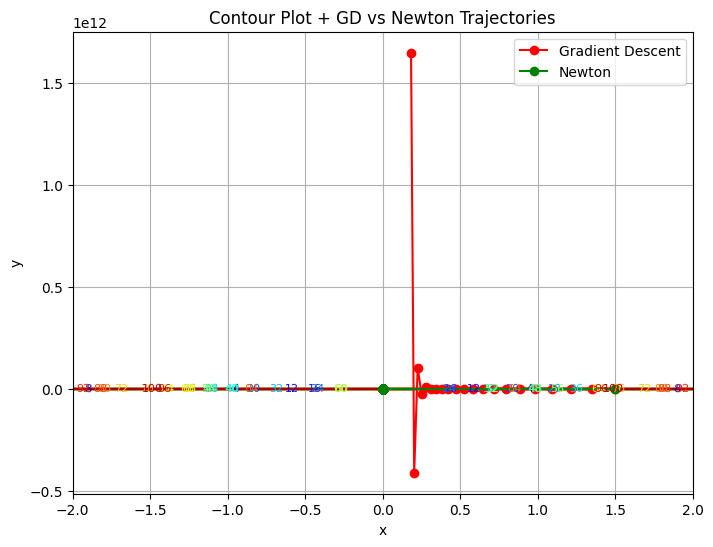

In [28]:
plt.figure(figsize=(8, 6))
contours = plt.contour(X, Y, Z, levels=30, cmap="jet")
plt.clabel(contours, inline=True, fontsize=8)
theta0 = np.array([1.5, 1.5])

gd_path = gradient_descent(theta0, lr=0.1, iters=20)
newton_path = newton_method(theta0, iters=300)
plt.plot(gd_path[:, 0], gd_path[:, 1], 'o-', color='red', label='Gradient Descent')
plt.plot(newton_path[:, 0], newton_path[:, 1], 'o-', color='green', label='Newton')
plt.title("Contour Plot + GD vs Newton Trajectories")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
def conjugate_gradient(theta0, iters):
    path = [theta0.copy()]
    theta = theta0.copy()
    r = grad(theta)
    p = -r
    for i in range(iters):
        Hp = H @ p
        alpha = (r.T @ r) / (p.T @ Hp)
        theta = theta + alpha * p
        path.append(theta.copy())
        r_new = r + alpha * Hp
        beta = (r_new.T @ r_new) / (r.T @ r)
        p = -r_new + beta * p
        r = r_new
    return np.array(path)